**STEP - 1 Load Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("EXOPLANET HABITABILITY PREDICTION MODEL")
print("=" * 80)

EXOPLANET HABITABILITY PREDICTION MODEL


**STEP - 1 Load Data**

In [2]:
print("\n[Step 1] Loading data...")

# Load your Excel file
df = pd.read_csv('More data added.csv')

print(f"✓ Loaded {len(df)} exoplanets")
print(f"✓ Features: {df.shape[1]} columns")


[Step 1] Loading data...
✓ Loaded 32806 exoplanets
✓ Features: 26 columns


**STEP -2 Create Habitability Labels**

In [3]:
print("\n[Step 2] Creating habitability labels...")

def assign_habitability(row):
    """
    Score planets based on habitability criteria
    Returns 1 if potentially habitable, 0 otherwise
    """
    score = 0

    # 1. Planet size (0.5-2.0 Earth radii = rocky planet)
    if pd.notna(row['pl_rade']):
        if 0.5 <= row['pl_rade'] <= 2.0:
            score += 2  # Strong indicator
        elif 2.0 < row['pl_rade'] <= 4.0:
            score += 1  # Possible mini-Neptune

    # 2. Habitable zone (0.25-4.0 Earth flux)
    if pd.notna(row['pl_insol']):
        if 0.25 <= row['pl_insol'] <= 4.0:
            score += 3  # Most important factor
        elif 0.1 <= row['pl_insol'] <= 10:
            score += 1

    # 3. Equilibrium temperature (200-320 K for liquid water) ⭐ NEW
    if pd.notna(row['pl_eqt']):
        if 200 <= row['pl_eqt'] <= 320:
            score += 2  # Ideal for liquid water
        elif 150 <= row['pl_eqt'] <= 400:
            score += 1  # Possible with atmosphere

    # 4. Orbital stability (eccentricity < 0.3)
    if pd.notna(row['pl_orbeccen']):
        if row['pl_orbeccen'] <= 0.3:
            score += 1

    # 5. Stellar temperature (2700-7200 K)
    if pd.notna(row['st_teff']):
        if 2700 <= row['st_teff'] <= 7200:
            score += 1

    # 6. Planet mass (0.1-10 Earth masses for atmosphere)
    if pd.notna(row['pl_bmasse']):
        if 0.1 <= row['pl_bmasse'] <= 10:
            score += 1

    # 7. Stellar mass (0.08-1.5 solar masses)
    if pd.notna(row['st_mass']):
        if 0.08 <= row['st_mass'] <= 1.5:
            score += 1

    # Need score >= 6 to be considered habitable
    return 1 if score >= 6 else 0

# Apply labeling
df['habitable'] = df.apply(assign_habitability, axis=1)

print(f"✓ Habitable planets: {df['habitable'].sum()} ({df['habitable'].mean()*100:.1f}%)")
print(f"✓ Non-habitable planets: {(df['habitable'] == 0).sum()} ({(1-df['habitable'].mean())*100:.1f}%)")


[Step 2] Creating habitability labels...
✓ Habitable planets: 11853 (36.1%)
✓ Non-habitable planets: 20953 (63.9%)


**STEP - 3 Prepare Features**

In [4]:
print("\n[Step 3] Preparing features...")

# Using SCALED columns - NOW WITH 11 FEATURES (added pl_eqt_scaled)
feature_cols = [
    'pl_orbper_scaled',   # Orbital Period
    'pl_orbsmax_scaled',  # Semi-major Axis
    'pl_rade_scaled',     # Planet Radius
    'pl_bmasse_scaled',   # Planet Mass
    'pl_orbeccen_scaled', # Orbital Eccentricity
    'pl_insol_scaled',    # Insolation Flux
    'pl_eqt_scaled',      # Equilibrium Temperature
    'st_teff_scaled',     # Stellar Temperature
    'st_rad_scaled',      # Stellar Radius
    'st_mass_scaled',     # Stellar Mass
    'st_met_scaled'       # Stellar Metallicity
]

# Remove rows with missing scaled features
df_clean = df.dropna(subset=feature_cols + ['habitable'])

print(f"✓ Clean dataset: {len(df_clean)} exoplanets")
print(f"✓ Dropped {len(df) - len(df_clean)} rows with missing values")
print(f"✓ Total features: {len(feature_cols)}")

# Prepare X (features) and y (target)
X = df_clean[feature_cols]
y = df_clean['habitable']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")



[Step 3] Preparing features...
✓ Clean dataset: 32804 exoplanets
✓ Dropped 2 rows with missing values
✓ Total features: 11
✓ Training set: 26243 samples
✓ Test set: 6561 samples


**STEP - 4 Training Multiple Model for Comparision**

In [6]:
print("\n[Step 4] Training models...")
print("-" * 80)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=42,
        early_stopping=True
    )
}

results = {}
best_accuracy = 0
best_model_name = ""

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Track best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

    # Print results
    print(f"  → Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  → AUC-ROC: {auc:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Habitable', 'Habitable']))

print("-" * 80)
print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy: {best_accuracy*100:.2f}%)")


[Step 4] Training models...
--------------------------------------------------------------------------------

Training Random Forest...
  → Accuracy: 0.9974 (99.74%)
  → AUC-ROC: 1.0000

  Classification Report:
               precision    recall  f1-score   support

Not Habitable       1.00      1.00      1.00      4190
    Habitable       0.99      1.00      1.00      2371

     accuracy                           1.00      6561
    macro avg       1.00      1.00      1.00      6561
 weighted avg       1.00      1.00      1.00      6561


Training Gradient Boosting...
  → Accuracy: 0.9994 (99.94%)
  → AUC-ROC: 1.0000

  Classification Report:
               precision    recall  f1-score   support

Not Habitable       1.00      1.00      1.00      4190
    Habitable       1.00      1.00      1.00      2371

     accuracy                           1.00      6561
    macro avg       1.00      1.00      1.00      6561
 weighted avg       1.00      1.00      1.00      6561


Training Logi

**STEP -5 Analyzing Important Feature**


[Step 5] Analyzing feature importance...

Feature Importance Rankings:
           feature  importance
    pl_rade_scaled    0.764199
   pl_insol_scaled    0.125341
     pl_eqt_scaled    0.085800
  pl_bmasse_scaled    0.016150
 pl_orbsmax_scaled    0.002766
pl_orbeccen_scaled    0.002551
  pl_orbper_scaled    0.001627
    st_mass_scaled    0.000847
    st_teff_scaled    0.000407
     st_rad_scaled    0.000286
     st_met_scaled    0.000026

✓ Saved feature importance plot: feature_importance.png


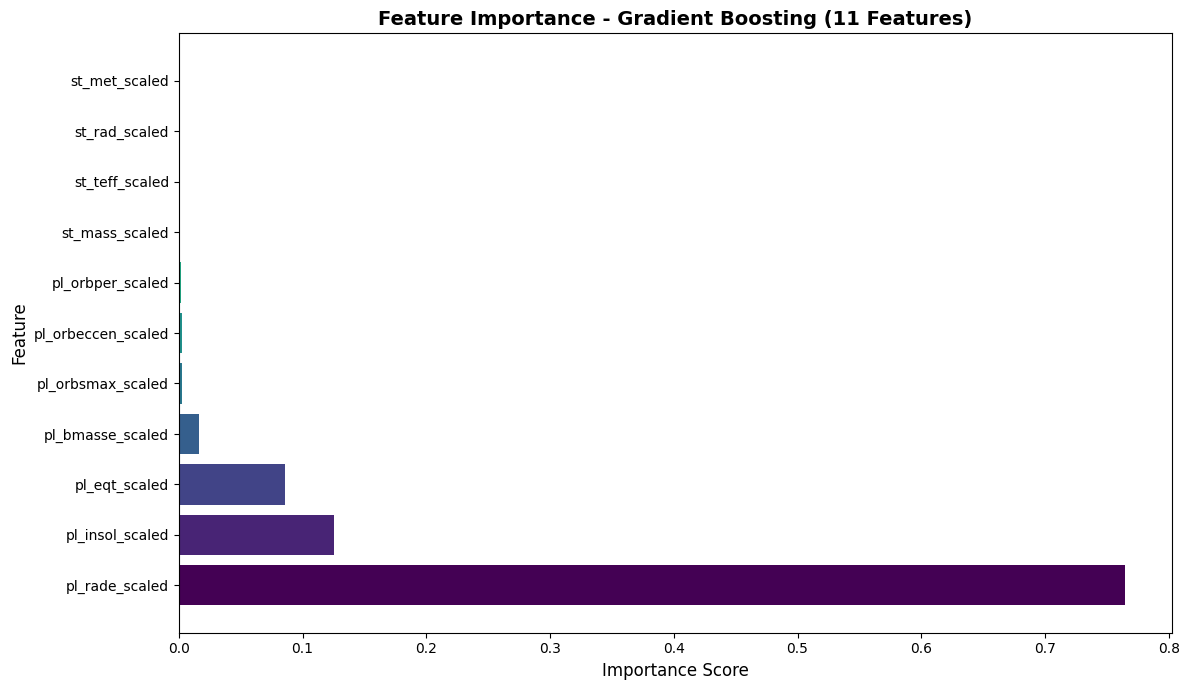

In [7]:
print("\n[Step 5] Analyzing feature importance...")

best_model = results[best_model_name]['model']

# Get feature importance (works for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance Rankings:")
    print(importance_df.to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(12, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name} (11 Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved feature importance plot: feature_importance.png")
    plt.show()

**STEP - 6 Save the Model and Evaluate for Predictions**





In [8]:
print("\n[Step 6] Saving model and generating predictions...")

# Save the best model
joblib.dump(best_model, 'exoplanet_habitability_model.pkl')
print("✓ Saved model: exoplanet_habitability_model.pkl")

# Add predictions to the original dataframe
df_clean['predicted_habitable'] = best_model.predict(X)
df_clean['habitability_probability'] = best_model.predict_proba(X)[:, 1]

# Save results
output_file = 'exoplanets_with_predictions.csv'
df_clean.to_csv(output_file, index=False)
print(f"✓ Saved predictions: {output_file}")


[Step 6] Saving model and generating predictions...
✓ Saved model: exoplanet_habitability_model.pkl
✓ Saved predictions: exoplanets_with_predictions.csv


**Step - 7 Saving individual model file separately**

In [9]:
print("\n[Step 7] Saving individual model files...")

# Save each model separately
for name, result in results.items():
    model_prefix = name.lower().replace(' ', '_')[:2]  # rf, gr, lo, ne

    # Save model
    model_filename = f'{model_prefix}_exoplanet_model.pkl'
    joblib.dump(result['model'], model_filename)
    print(f"✓ Saved: {model_filename}")

    # Save predictions with model-specific columns
    df_temp = df_clean.copy()
    df_temp['predicted_habitable'] = result['model'].predict(X)
    df_temp['habitability_probability'] = result['model'].predict_proba(X)[:, 1]

    pred_filename = f'{model_prefix}_predictions.csv'
    df_temp.to_csv(pred_filename, index=False)
    print(f"✓ Saved: {pred_filename}")


[Step 7] Saving individual model files...
✓ Saved: ra_exoplanet_model.pkl
✓ Saved: ra_predictions.csv
✓ Saved: gr_exoplanet_model.pkl
✓ Saved: gr_predictions.csv
✓ Saved: lo_exoplanet_model.pkl
✓ Saved: lo_predictions.csv
✓ Saved: ne_exoplanet_model.pkl
✓ Saved: ne_predictions.csv


**STEP - 8 Visuzlization**


[Step 8] Creating visualizations...
✓ Saved: confusion_matrix.png


<Figure size 800x600 with 0 Axes>

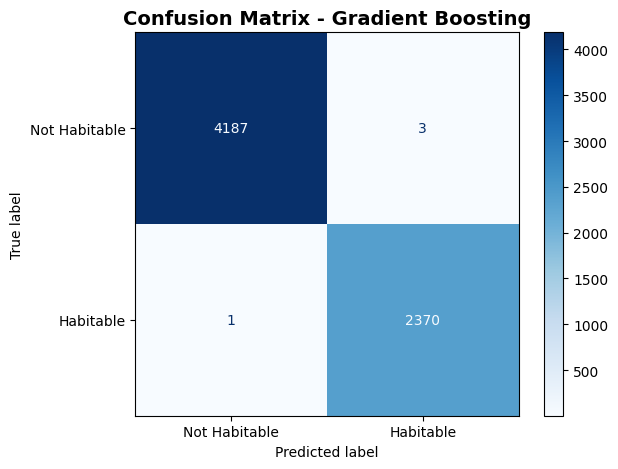

✓ Saved: model_comparison.png


<Figure size 1000x600 with 0 Axes>

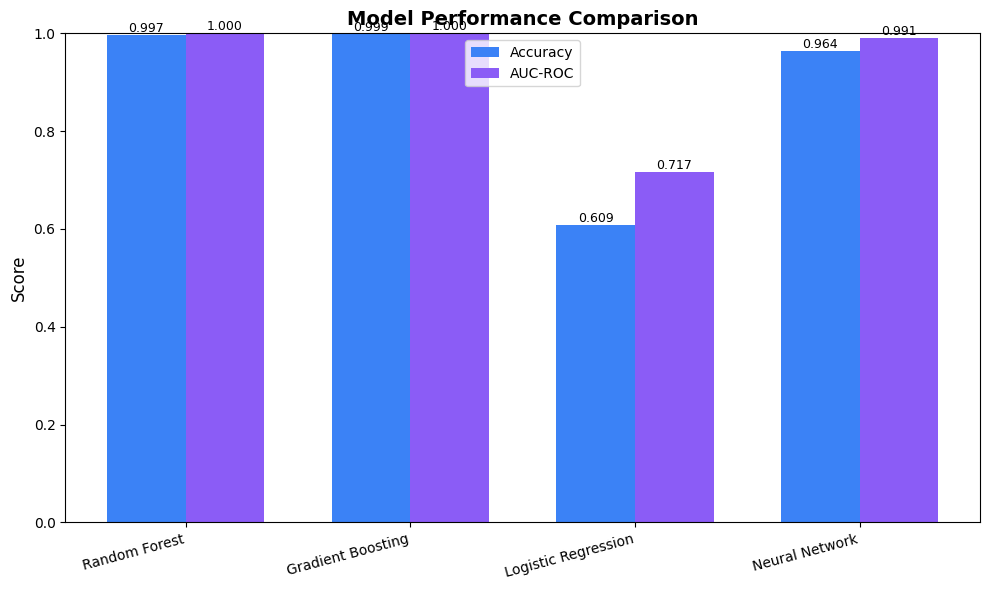

✓ Saved: habitability_distribution.png


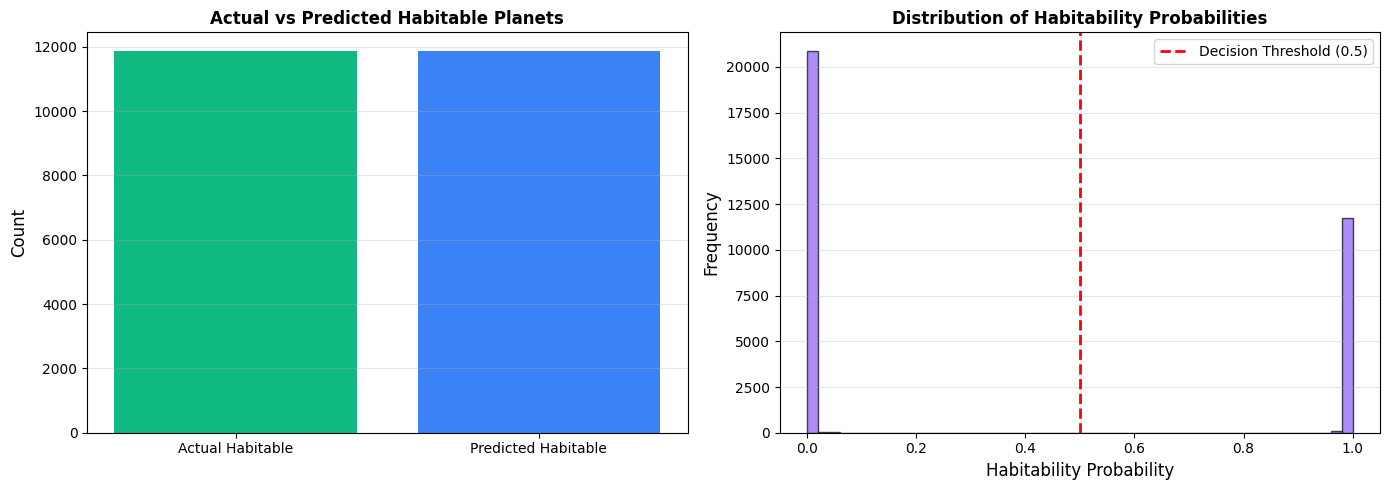

In [10]:
print("\n[Step 8] Creating visualizations...")

# 1. Confusion Matrix for Best Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Habitable', 'Habitable'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

# 2. Model Comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
aucs = [results[name]['auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#3b82f6')
bars2 = ax.bar(x + width/2, aucs, width, label='AUC-ROC', color='#8b5cf6')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_comparison.png")
plt.show()

# 3. Habitability Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].bar(['Actual Habitable', 'Predicted Habitable'],
            [df_clean['habitable'].sum(), df_clean['predicted_habitable'].sum()],
            color=['#10b981', '#3b82f6'])
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Actual vs Predicted Habitable Planets', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Probability Distribution
axes[1].hist(df_clean['habitability_probability'], bins=50, color='#8b5cf6', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Habitability Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Habitability Probabilities', fontsize=12, fontweight='bold')
axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('habitability_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: habitability_distribution.png")
plt.show()


**STEP - 9 Conclusion**

In [11]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Statistics:")
print(f"  • Total exoplanets analyzed: {len(df_clean)}")
print(f"  • Features used: {len(feature_cols)} (including pl_eqt_scaled)")
print(f"  • Labeled as habitable: {df_clean['habitable'].sum()}")
print(f"  • Predicted as habitable: {df_clean['predicted_habitable'].sum()}")

print(f"\n🎯 Model Performance:")
print(f"  • Best Model: {best_model_name}")
print(f"  • Accuracy: {best_accuracy*100:.2f}%")
print(f"  • AUC-ROC: {results[best_model_name]['auc']:.4f}")

print("\n🏆 All Model Accuracies:")
for name, result in results.items():
    print(f"  • {name}: {result['accuracy']*100:.2f}% (AUC: {result['auc']:.4f})")

print("\n🌍 Top 10 Most Likely Habitable Planets:")
top_habitable = df_clean.nlargest(10, 'habitability_probability')[
    ['pl_name', 'hostname', 'pl_rade', 'pl_eqt', 'predicted_habitable', 'habitability_probability']
]
print(top_habitable.to_string(index=False))

print("\n" + "=" * 80)
print("✅ COMPLETE! Model is ready to use.")
print("=" * 80)


SUMMARY

📊 Dataset Statistics:
  • Total exoplanets analyzed: 32804
  • Features used: 11 (including pl_eqt_scaled)
  • Labeled as habitable: 11853
  • Predicted as habitable: 11855

🎯 Model Performance:
  • Best Model: Gradient Boosting
  • Accuracy: 99.94%
  • AUC-ROC: 1.0000

🏆 All Model Accuracies:
  • Random Forest: 99.74% (AUC: 1.0000)
  • Gradient Boosting: 99.94% (AUC: 1.0000)
  • Logistic Regression: 60.89% (AUC: 0.7173)
  • Neural Network: 96.42% (AUC: 0.9907)

🌍 Top 10 Most Likely Habitable Planets:
      pl_name    hostname  pl_rade  pl_eqt  predicted_habitable  habitability_probability
Kepler-1126 b Kepler-1126    1.705  352.00                    1                  0.999937
 Kepler-347 d  Kepler-347    1.720  336.00                    1                  0.999937
  Kepler-48 d   Kepler-48    2.000  378.00                    1                  0.999937
 Kepler-779 b  Kepler-779    0.830  370.10                    1                  0.999937
 Kepler-779 b  Kepler-779    0.83

**STEP - 10 Predictions of new planet for habitability**

In [12]:
def predict_new_planet(planet_features_scaled):
    """
    Use this function to predict habitability for new exoplanets

    Args:
        planet_features_scaled: dict or DataFrame with scaled features

    Example:
        new_planet = {
            'pl_orbper_scaled': -0.39,
            'pl_orbsmax_scaled': 2.51,
            'pl_rade_scaled': -0.06,
            'pl_bmasse_scaled': -0.18,
            'pl_orbeccen_scaled': 6.47,
            'pl_insol_scaled': -0.25,
            'pl_eqt_scaled': 0.15,
            'st_teff_scaled': -6.98,
            'st_rad_scaled': -1.33,
            'st_mass_scaled': -3.18,
            'st_met_scaled': 1.34
        }
        predict_new_planet(new_planet)
    """
    # Convert dict to DataFrame if needed
    if isinstance(planet_features_scaled, dict):
        planet_features_scaled = pd.DataFrame([planet_features_scaled])

    # Make prediction
    prediction = best_model.predict(planet_features_scaled)[0]
    probability = best_model.predict_proba(planet_features_scaled)[0, 1]

    print(f"\n🔮 Prediction: {'✅ HABITABLE' if prediction == 1 else '❌ NOT HABITABLE'}")
    print(f"   Confidence: {probability*100:.1f}%")
    print(f"   Model Used: {best_model_name}")

    return prediction, probability

print("\n💡 TIP: Use predict_new_planet() function to classify new exoplanets!")
print("   Example: predict_new_planet({'pl_rade_scaled': -0.06, 'pl_eqt_scaled': 0.15, ...})")



💡 TIP: Use predict_new_planet() function to classify new exoplanets!
   Example: predict_new_planet({'pl_rade_scaled': -0.06, 'pl_eqt_scaled': 0.15, ...})


**All download confirmation**

In [13]:
print("\n[Step 11] Files ready for download:")
print("  • exoplanet_habitability_model.pkl (best model)")
print("  • exoplanets_with_predictions.csv (predictions)")
print("  • rf_exoplanet_model.pkl, gb_exoplanet_model.pkl, etc.")
print("  • feature_importance.png")
print("  • confusion_matrix.png")
print("  • model_comparison.png")
print("  • habitability_distribution.png")

# from google.colab import files
# files.download('exoplanet_habitability_model.pkl')
# files.download('exoplanets_with_predictions.csv')
# files.download('rf_exoplanet_model.pkl')
# files.download('gb_exoplanet_model.pkl')
# files.download('lr_exoplanet_model.pkl')
# files.download('ne_exoplanet_model.pkl')

print("\n" + "=" * 80)
print("🎉 ALL DONE! Your models are trained and ready for deployment!")
print("=" * 80)


[Step 11] Files ready for download:
  • exoplanet_habitability_model.pkl (best model)
  • exoplanets_with_predictions.csv (predictions)
  • rf_exoplanet_model.pkl, gb_exoplanet_model.pkl, etc.
  • feature_importance.png
  • confusion_matrix.png
  • model_comparison.png
  • habitability_distribution.png

🎉 ALL DONE! Your models are trained and ready for deployment!
